In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches


# Model agnostic 
from typing import Optional, List, Callable, Dict, Any, List
from pathlib import Path
from utils import ChiefBldr, QLatticeWrapper
from dft_model import DFT

This version of Feyn and the QLattice is available for academic, personal, and non-commercial use. By using the community version of this software you agree to the terms and conditions which can be found at https://abzu.ai/eula.

In [2]:
# Get the directory this file lives in
nb_dir = Path.cwd() # notebook directory
project_root = nb_dir.parents[0] # project directory
data_path = project_root / "datasets" / "processed_well_data.csv"

includ_cols = ['Dia', 'Dev(deg)','Area (m2)', 'z','GasDens','LiquidDens', 'g (m/s2)', 'P/T','friction_factor', 'critical_film_thickness']
D = ChiefBldr(path=data_path, includ_cols=includ_cols, test_size=0.20, scale=False)

In [3]:
# define xgboost pipeline
def dft(
        hparams: Dict[str, Any]
):
    dft = DFT(
        **hparams,
    )

    return dft

hparam_grid = {
            "dev_tol":   [1e-4, 1e-3, 1e-2],
            "feature_tol": [0.5, 1.0, 2.0],
            "multiple_dev_policy": ["max", "min", "mean"]
        }

# train model and optimize hyperparameters via grid search 
trained_model = D.evolv_model(build_model=dft, hparam_grid=hparam_grid, k_folds=5)

Training model and optimizing hyperparameters via k-fold CV...
Done. Best score = 0.6869875222816398
Best hyperparameters: {'dev_tol': 0.0001, 'feature_tol': 1.0, 'multiple_dev_policy': 'max'}
Retraining optimized model on full training set
Training set score: 0.9397590361445783
Test set score: 0.7142857142857143


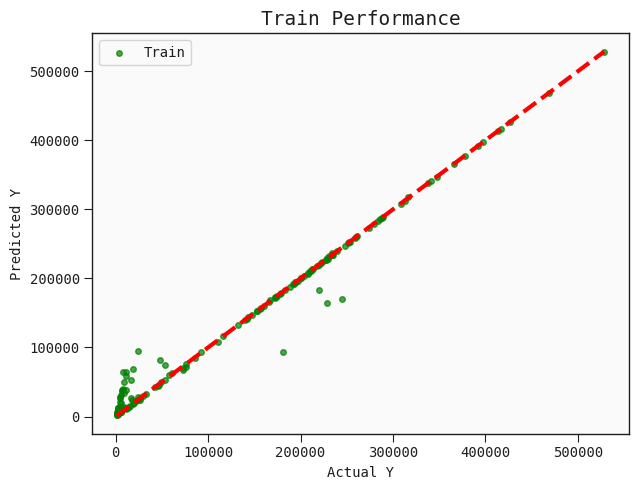

In [ ]:
   # Plot Training and Combined Performance
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(D.y_train, D.y_train_pred, label='Train', color='green', alpha=0.7)
plt.plot([D.y.min(), D.y.max()], [D.y.min(), D.y.max()], 'r--')
plt.xlabel("Actual Y")
plt.ylabel("Predicted Y")
plt.title("Train Performance")
plt.legend()


plt.tight_layout()
plt.show()


In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np

# Set publication-friendly plotting settings
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'Arial'  # Publication-friendly font
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# Define a light, publication-friendly color palette without green
color_map = {
    'Loaded': '#FF6363',  # Light red
    'Unloaded': '#3674B5',  # Light purple
    'Questionable': '#D3D3D3',  # Light orange
    'Near L.U': '#FFCC99'  # Light blue
}

colors = D.status_col.map(color_map).fillna('#D3D3D3')  # Light gray for missing values
y_pred = trained_model.predict(D.X)
# y_pred = D.scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
plt.figure(figsize=(8, 6), dpi=300)
sns.set_theme(style="whitegrid", context="paper", font_scale=1.3, font='Arial')
plt.scatter(D.gsflow , y_pred, c=colors, alpha=1, s=100, edgecolors="gray", linewidth=0.5)
plt.plot([0, 350000], [0, 350000], '--', color='#FF6666', linewidth=1.5)  # Light red dashed line
plt.title("XGBoost Model", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Measured Well Flow Rate (m³/day)", fontsize=14, fontweight='bold')
plt.ylabel("Predicted Critical Rate (m³/day)", fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0, 350000)
plt.ylim(0, 350000)
legend_patches = [mpatches.Patch(color=color, label=status) for status, color in color_map.items()]
plt.legend(handles=legend_patches, title='Actual Label', fontsize=12, title_fontsize=14, 
           loc='best', frameon=True, edgecolor='gray')
plt.tight_layout()
plt.savefig("xgboost_scatter.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

KeyError: (0, 1)